<a href="https://colab.research.google.com/github/WoradeeKongthong/nature_multilabel_image_classification/blob/main/03_pretrained_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CTRL + A then CTRL + / to uncomment
# CLONE PROJECT TO TRAIN IN GOOGLE COLAB
import os
if os.path.isdir('/content/nature_multilabel_image_classification'):
  !rm -rf '/content/nature_multilabel_image_classification'
  
!git clone https://github.com/WoradeeKongthong/nature_multilabel_image_classification.git

if not os.getcwd() == '/content/nature_multilabel_image_classification' :
  %cd /content/nature_multilabel_image_classification

!pwd

Cloning into 'nature_multilabel_image_classification'...
remote: Enumerating objects: 2050, done.
remote: Counting objects: 100% (2050/2050), done.
remote: Compressing objects: 100% (2038/2038), done.
remote: Total 2050 (delta 14), reused 2037 (delta 7), pack-reused 0
Receiving objects: 100% (2050/2050), 151.81 MiB | 24.72 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/nature_multilabel_image_classification
/content/nature_multilabel_image_classification


In [2]:
# prepared dataset
dataset_path = 'data/nature_data.npz'

# saved model name
model_name = 'best_pretrained_VGG16.h5'

# Nature Image Classification (Multi-labels)

## Objective 
To learn tags given to each image.  
There are 5 tags;  
- desert  
- mountains  
- sea  
- sunset  
- trees  

## Dataset
source : https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip?dl=0  
(You can follow the tutorial in this blog https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24)

## Approach
Baseline model : CNN model with 1,2 or 3 VGG block(s)  

Improved model 
- dropout
- data augmentation

## Load dataset from file

In [3]:
import numpy as np

In [4]:
# load data
data = np.load(dataset_path)
X, y = data['arr_0'], data['arr_1']
print('X shape : ', X.shape)
print('y shape : ', y.shape)

X shape :  (2000, 128, 128, 3)
y shape :  (2000, 5)


## Create train and test set
(Note : validation set will be created with ImageDataGenerator)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [7]:
print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)
print()
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (1600, 128, 128, 3)
y_train shape :  (1600, 5)

X_test shape :  (400, 128, 128, 3)
y_test shape :  (400, 5)


## Create data generator without data augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

In [9]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

## fbeta score function for multi-label problem

In [10]:
from tensorflow.keras import backend

# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

In [11]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Baseline Model

### Baseline model : 

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [13]:
# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

58900480/58889256 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [15]:
# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

Epoch 1/200
64/64 [==============================] - 38s 98ms/step - loss: 0.7951 - fbeta: 0.7353 - val_loss: 0.3224 - val_fbeta: 0.7514
Epoch 2/200
64/64 [==============================] - 6s 92ms/step - loss: 0.1576 - fbeta: 0.8939 - val_loss: 0.3047 - val_fbeta: 0.8157
Epoch 3/200
64/64 [==============================] - 6s 94ms/step - loss: 0.0715 - fbeta: 0.9500 - val_loss: 0.3271 - val_fbeta: 0.7942
Epoch 4/200
64/64 [==============================] - 6s 93ms/step - loss: 0.0398 - fbeta: 0.9765 - val_loss: 0.3665 - val_fbeta: 0.8142
Epoch 5/200
64/64 [==============================] - 6s 94ms/step - loss: 0.0255 - fbeta: 0.9834 - val_loss: 0.3714 - val_fbeta: 0.8064
Epoch 6/200
64/64 [==============================] - 6s 94ms/step - loss: 0.0178 - fbeta: 0.9856 - val_loss: 0.3711 - val_fbeta: 0.8244
Epoch 7/200
64/64 [==============================] - 6s 93ms/step - loss: 0.0157 - fbeta: 0.9900 - val_loss: 0.3926 - val_fbeta: 0.8288
Epoch 8/200
64/64 [============================

In [16]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

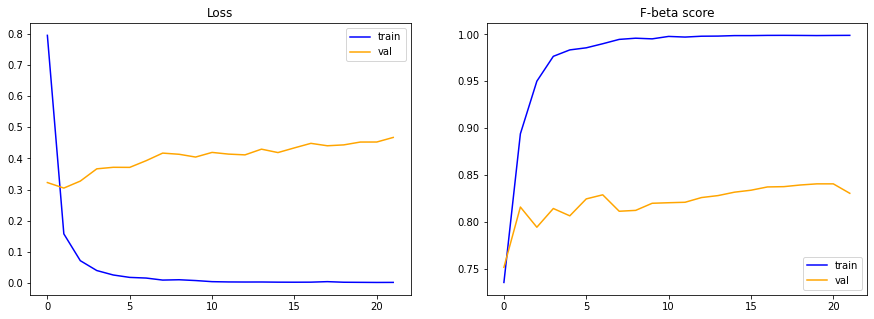

Model F-beta score :  0.8260606527328491


In [17]:
baseline_perf = evaluate_model(history)

Note : overfitting

## Improved Models

### model 1 : set last VGG block as trainable

Epoch 1/200
64/64 [==============================] - 9s 112ms/step - loss: 755.7322 - fbeta: 0.1102 - val_loss: 0.6399 - val_fbeta: 0.0000e+00
Epoch 2/200
64/64 [==============================] - 7s 107ms/step - loss: 3.1302 - fbeta: 0.0220 - val_loss: 162.2780 - val_fbeta: 0.0279
Epoch 3/200
64/64 [==============================] - 7s 107ms/step - loss: 2.8372 - fbeta: 0.0149 - val_loss: 0.5686 - val_fbeta: 0.0000e+00
Epoch 4/200
64/64 [==============================] - 7s 107ms/step - loss: 0.5576 - fbeta: 0.0000e+00 - val_loss: 0.5640 - val_fbeta: 0.0000e+00
Epoch 5/200
64/64 [==============================] - 7s 107ms/step - loss: 0.5539 - fbeta: 0.0000e+00 - val_loss: 0.5630 - val_fbeta: 0.0000e+00
Epoch 6/200
64/64 [==============================] - 7s 108ms/step - loss: 0.5528 - fbeta: 0.0000e+00 - val_loss: 0.5632 - val_fbeta: 0.0000e+00
Epoch 7/200
64/64 [==============================] - 7s 108ms/step - loss: 0.5526 - fbeta: 0.0000e+00 - val_loss: 0.5636 - val_fbeta: 0.0000e+

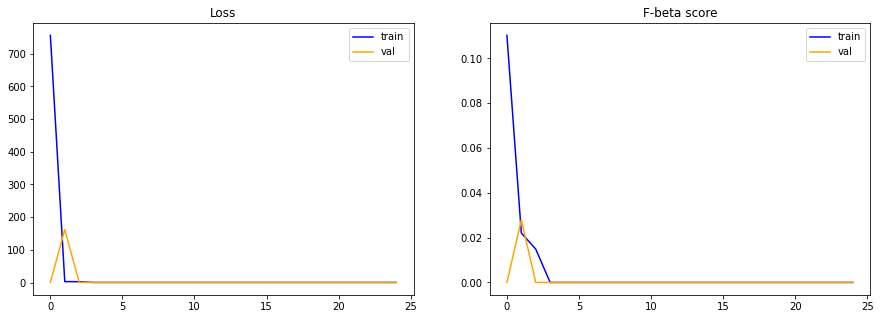

Model F-beta score :  0.0


In [18]:
# create image data generator
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# mark last vgg block as trainable
model.get_layer('block5_conv1').trainable = True
model.get_layer('block5_conv2').trainable = True
model.get_layer('block5_conv3').trainable = True
model.get_layer('block5_pool').trainable = True
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# optimizer 
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.01)

# compile model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model1_perf = evaluate_model(history)

Note : model doesn't learn properly, need to adjust learning rate

### model 2 : Baseline model + dropout layer

Epoch 1/200
64/64 [==============================] - 7s 98ms/step - loss: 1.1157 - fbeta: 0.7084 - val_loss: 0.2996 - val_fbeta: 0.8084
Epoch 2/200
64/64 [==============================] - 6s 94ms/step - loss: 0.2978 - fbeta: 0.8341 - val_loss: 0.2401 - val_fbeta: 0.8280
Epoch 3/200
64/64 [==============================] - 6s 95ms/step - loss: 0.1744 - fbeta: 0.8903 - val_loss: 0.2547 - val_fbeta: 0.8165
Epoch 4/200
64/64 [==============================] - 6s 94ms/step - loss: 0.1209 - fbeta: 0.9200 - val_loss: 0.2534 - val_fbeta: 0.8305
Epoch 5/200
64/64 [==============================] - 6s 94ms/step - loss: 0.1019 - fbeta: 0.9390 - val_loss: 0.2748 - val_fbeta: 0.8353
Epoch 6/200
64/64 [==============================] - 6s 96ms/step - loss: 0.0984 - fbeta: 0.9429 - val_loss: 0.2910 - val_fbeta: 0.8057
Epoch 7/200
64/64 [==============================] - 6s 94ms/step - loss: 0.0701 - fbeta: 0.9598 - val_loss: 0.3058 - val_fbeta: 0.8312
Epoch 8/200
64/64 [=============================

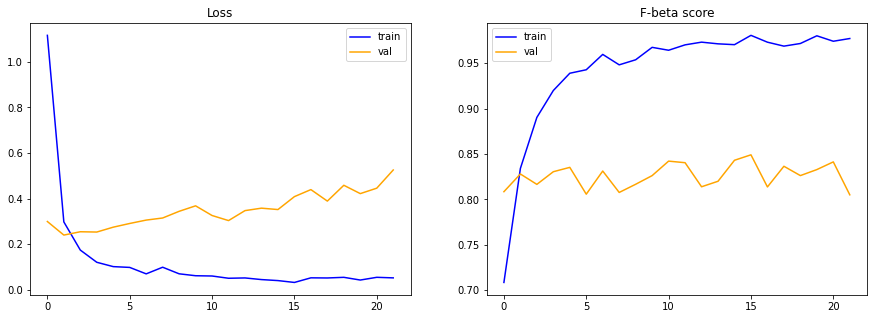

Model F-beta score :  0.8120419383049011


In [19]:
# create image data generator
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)

# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model2_perf = evaluate_model(history)

Note : overfitting, fbeta score is lower

### model 3 : Baseline model + data augmentation

Epoch 1/200
64/64 [==============================] - 10s 141ms/step - loss: 1.1480 - fbeta: 0.5766 - val_loss: 0.4468 - val_fbeta: 0.6383
Epoch 2/200
64/64 [==============================] - 8s 132ms/step - loss: 0.3809 - fbeta: 0.6539 - val_loss: 0.3517 - val_fbeta: 0.6571
Epoch 3/200
64/64 [==============================] - 9s 133ms/step - loss: 0.3115 - fbeta: 0.7162 - val_loss: 0.3461 - val_fbeta: 0.6458
Epoch 4/200
64/64 [==============================] - 8s 132ms/step - loss: 0.2760 - fbeta: 0.7370 - val_loss: 0.3422 - val_fbeta: 0.7234
Epoch 5/200
64/64 [==============================] - 9s 133ms/step - loss: 0.2552 - fbeta: 0.7590 - val_loss: 0.3148 - val_fbeta: 0.7296
Epoch 6/200
64/64 [==============================] - 8s 132ms/step - loss: 0.2481 - fbeta: 0.7772 - val_loss: 0.3083 - val_fbeta: 0.7097
Epoch 7/200
64/64 [==============================] - 8s 132ms/step - loss: 0.2252 - fbeta: 0.7951 - val_loss: 0.2931 - val_fbeta: 0.7699
Epoch 8/200
64/64 [=====================

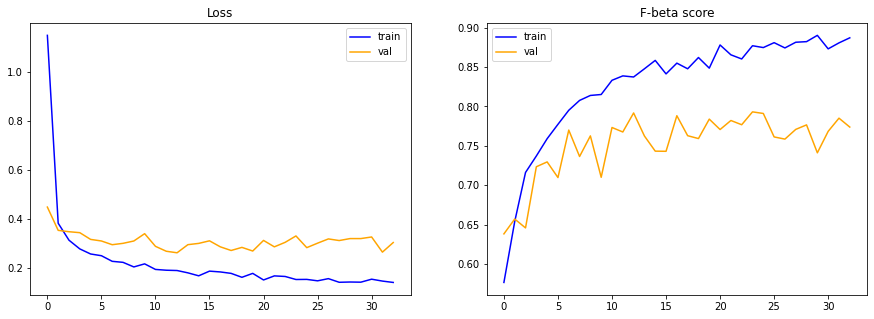

Model F-beta score :  0.8327091336250305


In [20]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model3_perf = evaluate_model(history)

Note : overfitting is reduced, fbeta score is high

### model 4 : Baseline model + data augmentation + dropout layers

Epoch 1/200
64/64 [==============================] - 10s 140ms/step - loss: 1.3553 - fbeta: 0.4892 - val_loss: 0.4463 - val_fbeta: 0.5728
Epoch 2/200
64/64 [==============================] - 9s 134ms/step - loss: 0.4528 - fbeta: 0.5496 - val_loss: 0.3926 - val_fbeta: 0.6172
Epoch 3/200
64/64 [==============================] - 9s 140ms/step - loss: 0.4194 - fbeta: 0.5564 - val_loss: 0.3851 - val_fbeta: 0.5847
Epoch 4/200
64/64 [==============================] - 9s 137ms/step - loss: 0.3741 - fbeta: 0.6121 - val_loss: 0.3762 - val_fbeta: 0.6019
Epoch 5/200
64/64 [==============================] - 9s 136ms/step - loss: 0.3473 - fbeta: 0.6549 - val_loss: 0.3652 - val_fbeta: 0.6934
Epoch 6/200
64/64 [==============================] - 9s 135ms/step - loss: 0.3246 - fbeta: 0.6862 - val_loss: 0.3418 - val_fbeta: 0.6305
Epoch 7/200
64/64 [==============================] - 9s 138ms/step - loss: 0.3026 - fbeta: 0.7124 - val_loss: 0.3355 - val_fbeta: 0.6828
Epoch 8/200
64/64 [=====================

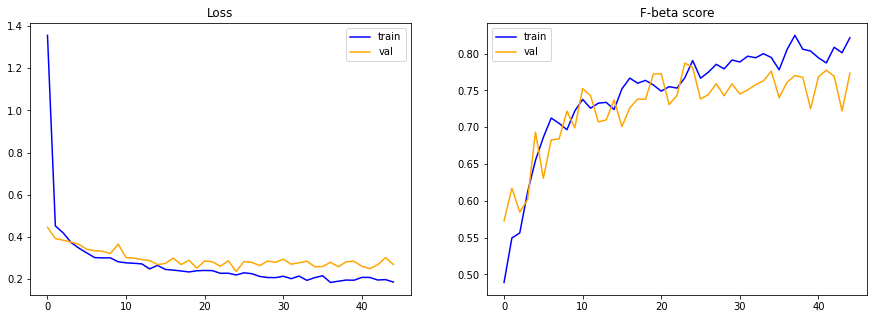

Model F-beta score :  0.8210804462432861


In [21]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model4_perf = evaluate_model(history)

Note : overfitting is reduced but get increase again in later epochs.

### model 5 : Baseline model + data augmentation + dropout layers + more dense layers

Epoch 1/200
64/64 [==============================] - 10s 139ms/step - loss: 2.2971 - fbeta: 0.4190 - val_loss: 0.5338 - val_fbeta: 0.5397
Epoch 2/200
64/64 [==============================] - 9s 133ms/step - loss: 0.7437 - fbeta: 0.4914 - val_loss: 0.4238 - val_fbeta: 0.5574
Epoch 3/200
64/64 [==============================] - 9s 134ms/step - loss: 0.5446 - fbeta: 0.4426 - val_loss: 0.4335 - val_fbeta: 0.4477
Epoch 4/200
64/64 [==============================] - 9s 133ms/step - loss: 0.5032 - fbeta: 0.4198 - val_loss: 0.3867 - val_fbeta: 0.5576
Epoch 5/200
64/64 [==============================] - 9s 133ms/step - loss: 0.4880 - fbeta: 0.4374 - val_loss: 0.3898 - val_fbeta: 0.5675
Epoch 6/200
64/64 [==============================] - 9s 134ms/step - loss: 0.4709 - fbeta: 0.4648 - val_loss: 0.3706 - val_fbeta: 0.5111
Epoch 7/200
64/64 [==============================] - 9s 134ms/step - loss: 0.4559 - fbeta: 0.4466 - val_loss: 0.3776 - val_fbeta: 0.4677
Epoch 8/200
64/64 [=====================

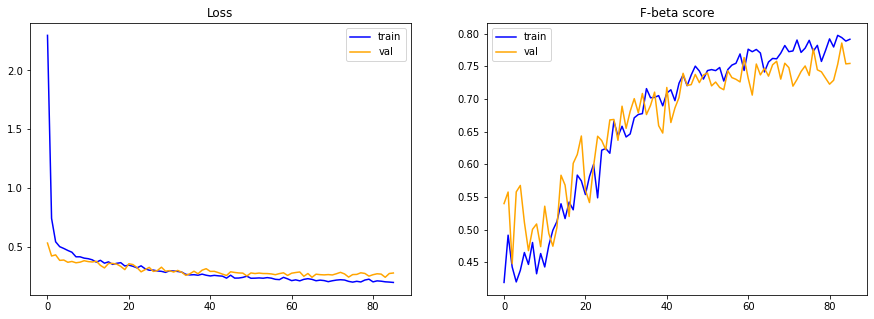

Model F-beta score :  0.8138582706451416


In [22]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.3)(class1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.3)(class2)
output = Dense(5, activation='sigmoid')(dropout3)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model5_perf = evaluate_model(history)

Note : overfitting is reduced

In [23]:
print('Baseline model : ', baseline_perf)
print('Model 1 : ', model1_perf)
print('Model 2 : ', model2_perf)
print('Model 3 : ', model3_perf)
print('Model 4 : ', model4_perf)
print('Model 5 : ', model5_perf)

Baseline model :  0.8260606527328491
Model 1 :  0.0
Model 2 :  0.8120419383049011
Model 3 :  0.8327091336250305
Model 4 :  0.8210804462432861
Model 5 :  0.8138582706451416


Note : 
- model 2, 3  are overfitting  
- model 4, 5 overfitting is reduced

## Finalize model 5
Train the selected model again.  
Give it more time to learn.  
Save the highest performance with ModelCheckpoint.

Epoch 1/300
64/64 [==============================] - 10s 139ms/step - loss: 2.3022 - fbeta: 0.4544 - val_loss: 0.5806 - val_fbeta: 0.5751

Epoch 00001: val_loss improved from inf to 0.58059, saving model to best_pretrained_VGG16.h5
Epoch 2/300
64/64 [==============================] - 9s 135ms/step - loss: 0.8097 - fbeta: 0.5207 - val_loss: 0.4074 - val_fbeta: 0.5783

Epoch 00002: val_loss improved from 0.58059 to 0.40744, saving model to best_pretrained_VGG16.h5
Epoch 3/300
64/64 [==============================] - 9s 135ms/step - loss: 0.5798 - fbeta: 0.4474 - val_loss: 0.4426 - val_fbeta: 0.4813

Epoch 00003: val_loss did not improve from 0.40744
Epoch 4/300
64/64 [==============================] - 9s 136ms/step - loss: 0.5388 - fbeta: 0.4436 - val_loss: 0.4307 - val_fbeta: 0.4923

Epoch 00004: val_loss did not improve from 0.40744
Epoch 5/300
64/64 [==============================] - 9s 134ms/step - loss: 0.4788 - fbeta: 0.4882 - val_loss: 0.3865 - val_fbeta: 0.5373

Epoch 00005: val_

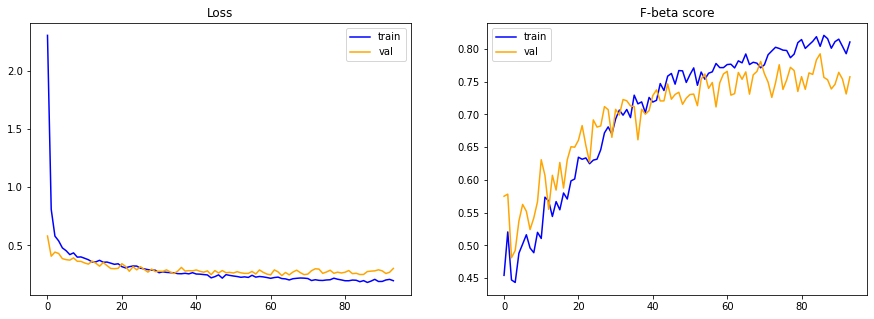

Model F-beta score :  0.8102471232414246


In [26]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.3)(class1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.3)(class2)
output = Dense(5, activation='sigmoid')(dropout3)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# create model checkpoint to save the model
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es, mc],
                    epochs=300)
final_model_perf = evaluate_model(history)

## Evaluate model

In [29]:
# print model score
final_model_fbeta = model.evaluate(test_iter)[1]
print('final_model_fbeta : ', final_model_fbeta)

400/400 [==============================] - 7s 18ms/step - loss: 0.2362 - fbeta: 0.8102
final_model_fbeta :  0.8102471232414246


## Save model to local machine

In [30]:
# load saved model file to local machine
from google.colab import files
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>